In [24]:
import numpy as np
import pandas as pd
from typing import Union
from itertools import product
from tqdm import tqdm_notebook
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/air-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
df

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [4]:
np.arange(1949, 1962)

array([1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
       1960, 1961])

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:2019: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:249: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:251: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


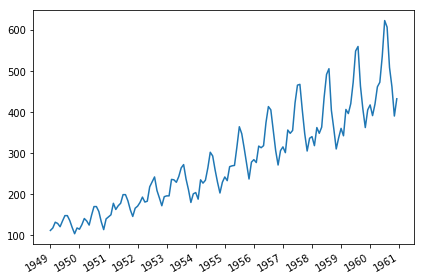

In [5]:
fig, ax = plt.subplots()
ax.plot(df['Month'], df['Passengers'])
plt.xticks(
    np.arange(0, 145, 12),
    np.arange(1949, 1962)
)
fig.autofmt_xdate()
plt.tight_layout()

## Decompose dataset to identify seasonal component

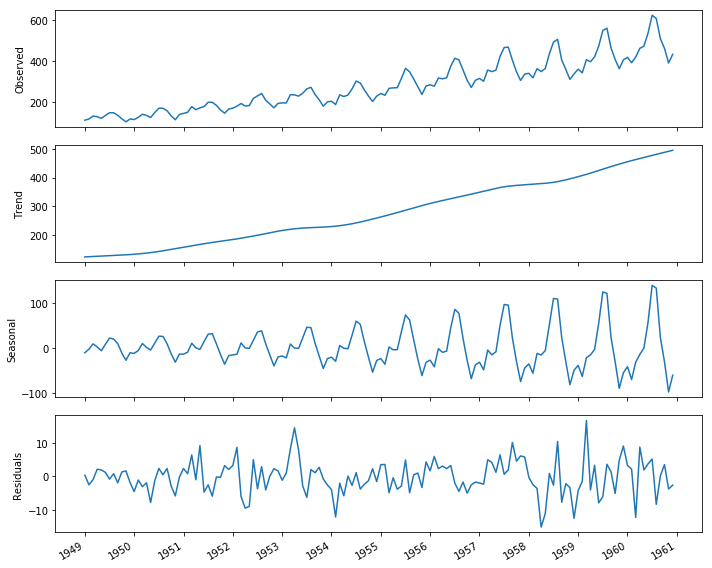

In [6]:
decomposition = STL(df['Passengers'], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(10, 8))
ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(
    np.arange(0, 145, 12),
    np.arange(1949, 1962)
)
fig.autofmt_xdate()
plt.tight_layout()

**Note:** In a situation where we have a time series with no seasonal pattern, the decomposition process will display a flat horizontal line at 0 for the seasonal component

## Forecasting the number of monthly air passengers

### Forecasting with an ARIMA(p,d,q) model

In [8]:
ADF_result = adfuller(df['Passengers'])
print('ADF Statistics: {}'.format(ADF_result[0]))
print('p-value: {}'.format(ADF_result[1]))

ADF Statistics: 0.8153688792060418
p-value: 0.9918802434376409


The series is **not stationary**

In [9]:
df_diff = np.diff(df['Passengers'], n=1)
ADF_result = adfuller(df_diff)
print('ADF Statistics: {}'.format(ADF_result[0]))
print('p-value: {}'.format(ADF_result[1]))

ADF Statistics: -2.829266824169997
p-value: 0.05421329028382577


Again the series is **not stationary**

In [11]:
df_diff2 = np.diff(df['Passengers'], n=2)
ADF_result = adfuller(df_diff2)
print('ADF Statistics: {}'.format(ADF_result[0]))
print('p-value: {}'.format(ADF_result[1]))

ADF Statistics: -16.384231542468513
p-value: 2.7328918500142026e-29


Series is considered to be **stationary**

In [15]:
ps = range(0, 13)
qs = range(0, 13)
Ps = [0]
Qs = [0]

d = 2
D = 0
s = 12

ARIMA_order_list = list(product(ps, qs, Ps, Qs))
print('There are {} combinations'.format(len(ARIMA_order_list)))

There are 169 combinations


SARIMA(p,d,q)(0,0,0)_m model is equivalent to an ARIMA(p,d,q) model

In [18]:
def optimize_SARIMA(
    endog: Union[pd.Series, list],
    order_list: list,
    d: int,
    D: int,
    s: int
) -> pd.DataFrame:
    
    results = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False
            ).fit(disp=False)
        except:
            continue
        
        aic = model.aic
        results.append([order, aic])
    
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    # Sort
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [19]:
train = df['Passengers'][:-12]
ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s)
ARIMA_result_df

/home/msdc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


/home/msdc/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/m

/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/msdc/.local/lib/python3.6/site-packages/statsmode

/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/msdc/.local/lib/python3.6/site-packages/statsmode

/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


,"(p,q,P,Q)",AIC
0,"(11, 3, 0, 0)",1016.846315
1,"(11, 4, 0, 0)",1019.035066
2,"(11, 5, 0, 0)",1020.378072
3,"(11, 1, 0, 0)",1021.024227
4,"(12, 0, 0, 0)",1021.153445
...,...,...
164,"(5, 0, 0, 0)",1281.732157
165,"(3, 0, 0, 0)",1300.282335
166,"(2, 0, 0, 0)",1302.913196
167,"(1, 0, 0, 0)",1308.152194


In [21]:
ARIMA_result_df.head()

,"(p,q,P,Q)",AIC
0,"(11, 3, 0, 0)",1016.846315
1,"(11, 4, 0, 0)",1019.035066
2,"(11, 5, 0, 0)",1020.378072
3,"(11, 1, 0, 0)",1021.024227
4,"(12, 0, 0, 0)",1021.153445


In [22]:
ARIMA_model = SARIMAX(train, order=(11, 2, 3), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)

/home/msdc/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/msdc/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


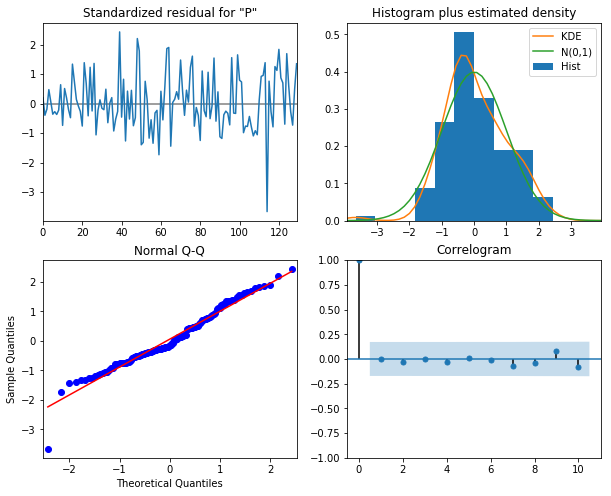

In [23]:
ARIMA_model_fit.plot_diagnostics(figsize=(10, 8));

In [25]:
residuals = ARIMA_model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11))
print(pvalue)

[0.01050458 0.03555564 0.0736765  0.10147096 0.13612511 0.19262388
 0.21906043 0.28432366 0.37175268 0.31791423]


/home/msdc/.local/lib/python3.6/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


The returned p-values are all greater than 0.05 except for the first two values. This means that, according to the Ljung-Box test, we reject the null hypothesis with a 5% chance of being wrong, since we set our significance boundary to 0.05. However, the third value and onwards are all greater than 0.05, so we reject the null hypothesis, concluding that the residuals are uncorrelated starting at lag 3.

This means that our ARIMA model is not capturing all the information from the data. Therefore, the Ljung-Box test is really telling us that our model is not perfect, but that’s okay

In [26]:
test = df.iloc[-12:]
test['naive_seasonal'] = df['Passengers'].iloc[120:132].values
ARIMA_pred = ARIMA_model_fit.get_prediction(132, 143).predicted_mean
test['ARIMA_pred'] = ARIMA_pred

test

/home/msdc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/msdc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Month,Passengers,naive_seasonal,ARIMA_pred
132,1960-01,417,360,422.287154
133,1960-02,391,342,410.646698
134,1960-03,419,406,461.826773
135,1960-04,461,396,457.735076
136,1960-05,472,420,481.612666
137,1960-06,535,472,530.962602
138,1960-07,622,548,606.124228
139,1960-08,606,559,615.423552
140,1960-09,508,463,525.646650
141,1960-10,461,407,467.177130


### Forecasting with a SARIMA(p,d,q)(P,D,Q)_m model

In [27]:
ADF_result = adfuller(df['Passengers'])
print('ADF Statistics: {}'.format(ADF_result[0]))
print('p-value: {}'.format(ADF_result[1]))

ADF Statistics: 0.8153688792060418
p-value: 0.9918802434376409


In [28]:
df_diff = np.diff(df['Passengers'], n=1)
ADF_result = adfuller(df_diff)
print('ADF Statistics: {}'.format(ADF_result[0]))
print('p-value: {}'.format(ADF_result[1]))

ADF Statistics: -2.829266824169997
p-value: 0.05421329028382577


In [29]:
df_diff2 = np.diff(df['Passengers'], n=2)
ADF_result = adfuller(df_diff2)
print('ADF Statistics: {}'.format(ADF_result[0]))
print('p-value: {}'.format(ADF_result[1]))

ADF Statistics: -16.384231542468513
p-value: 2.7328918500142026e-29


In [30]:
df_diff_seasonal_diff = np.diff(df_diff, n=12)
ad_fuller_result = adfuller(df_diff_seasonal_diff)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -17.624862360072264
p-value: 3.823046856364629e-30


In [32]:
ps = range(0, 4)
qs = range(0, 4)
Ps = range(0, 4)
Qs = range(0, 4)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 1
s = 12

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df

/home/msdc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


/home/msdc/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/msdc/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed

/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/msdc/.local/lib/python3.6/site-packages/statsmode

/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/msdc/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/msdc/.local/lib/python3.6/site-packages/statsmode

,"(p,q,P,Q)",AIC
0,"(2, 1, 1, 2)",892.247531
1,"(2, 1, 2, 1)",893.560625
2,"(2, 1, 1, 3)",894.105883
3,"(1, 0, 1, 2)",894.290769
4,"(2, 1, 2, 3)",894.961403
...,...,...
251,"(0, 0, 2, 0)",906.940147
252,"(3, 2, 0, 3)",907.181875
253,"(0, 0, 3, 2)",907.426600
254,"(0, 0, 3, 0)",908.742583


In [33]:
SARIMA_model = SARIMAX(train, order=(2, 1, 1), seasonal_order=(1, 1, 2, 12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

/home/msdc/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/msdc/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


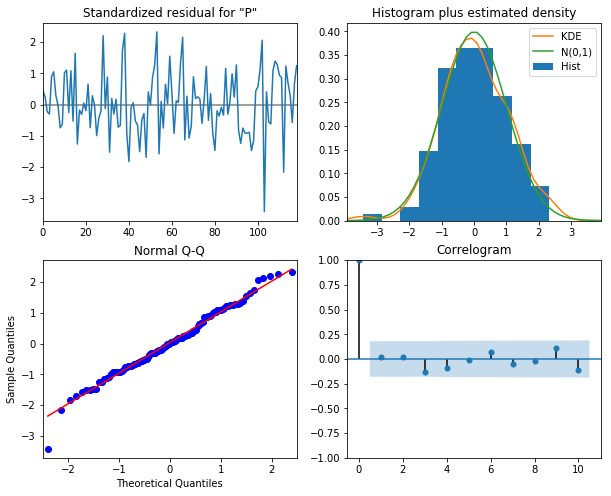

In [34]:
SARIMA_model_fit.plot_diagnostics(figsize=(10, 8));

In [35]:
residuals = SARIMA_model_fit.resid
lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11))
print(pvalue)

[0.94200785 0.69010084 0.79732828 0.87441098 0.92057193 0.94448955
 0.94119219 0.9510754  0.97408796 0.89360683]


/home/msdc/.local/lib/python3.6/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [36]:
SARIMA_pred = SARIMA_model_fit.get_prediction(132, 143).predicted_mean
test['SARIMA_pred'] = SARIMA_pred

/home/msdc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Comparing the performance of each forecasting method

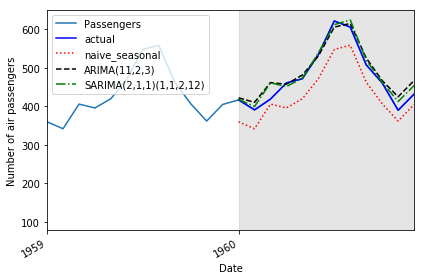

In [41]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
ax.plot(test['Passengers'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive_seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(11,2,3)')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA(2,1,1)(1,1,2,12)')

ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
ax.axvspan(132, 143, color='#808080', alpha=0.2)
ax.legend(loc=2)
plt.xticks(
    np.arange(0, 145, 12),
    np.arange(1949, 1962)
)
ax.set_xlim(120, 143)
fig.autofmt_xdate()
plt.tight_layout()

In [42]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [43]:
mape_naive_seasonal = mape(test['Passengers'], test['naive_seasonal'])
mape_ARIMA = mape(test['Passengers'], test['ARIMA_pred'])
mape_SARIMA = mape(test['Passengers'], test['SARIMA_pred'])

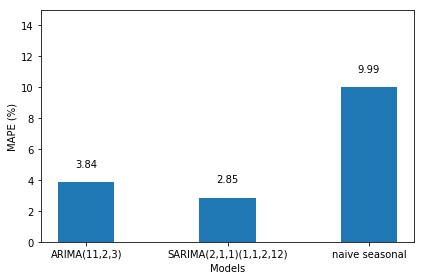

In [67]:
fig, ax = plt.subplots()
x = ['naive seasonal', 'ARIMA(11,2,3)', 'SARIMA(2,1,1)(1,1,2,12)']
y = [mape_naive_seasonal, mape_ARIMA, mape_SARIMA]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate([mape_ARIMA, mape_SARIMA, mape_naive_seasonal]):
    plt.text(x=index, y=value + 1, s=str(round(value, 2)), ha='center')
    
plt.tight_layout()